In [25]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using Dates
using ColorSchemes
using Statistics
using GeoDatasets
cmapS = ColorSchemes.haline
include("../config.jl")

"https://dox.uliege.be/index.php/s/qJtEotmkCZVqcx8/download"

In [14]:
import Pkg; Pkg.add("ColorSchemes");
Pkg.add("GeoDatasets")

   Resolving package versions...
  No Changes to `~/Projects/Diva-Workshops/Project.toml`
  No Changes to `~/Projects/Diva-Workshops/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/Diva-Workshops/Project.toml`
  No Changes to `~/Projects/Diva-Workshops/Manifest.toml`


## Extract land-sea mask (high-res)

In [15]:
lonmask,latmask, mask = GeoDatasets.landseamask(;resolution='f',grid=1.25)
goodlon = findall((lonmask .>= lonr[1]) .& (lonmask .<= lonr[end]))
goodlat = findall((latmask .>= latr[1]) .& (latmask .<= latr[end]))
lonmask = lonmask[goodlon]
latmask = latmask[goodlat]
mask = mask[goodlon, goodlat];

mask[mask.==2] .= 1;

In [16]:
datafile = adriaticfile
download_check(datafile, adriaticfileURL)
bathfile = gebco04file
download_check(bathfile, gebco04fileURL)

[ Info: File already downloaded
[ Info: File already downloaded


In [17]:
@time obsval, obslon, obslat, obsdepth, obstime, obsid =
    NCODV.load(Float64, datafile, "Water body salinity");

  6.425690 seconds (13.14 M allocations: 911.673 MiB, 3.05% gc time, 78.40% compilation time)


In [18]:
dx, dy = 0.05, 0.05
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1), Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,10.,20.];

## Metrics and mask

In [19]:
_, (pm,pn), (xi,yi) = DIVAnd_rectdom(lonr, latr)

(Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], ([19.999999999999716 19.999999999999716 … 19.999999999999716 19.999999999999716; 20.00000000000007 20.00000000000007 … 20.00000000000007 20.00000000000007; … ; 19.999999999999716 19.999999999999716 … 19.999999999999716 19.999999999999716; 19.999999999999716 19.999999999999716 … 19.999999999999716 19.999999999999716], [20.000000000001137 19.999999999999716 … 19.999999999999716 20.000000000001137; 20.000000000001137 19.999999999999716 … 19.999999999999716 20.000000000001137; … ; 20.000000000001137 19.999999999999716 … 19.999999999999716 20.000000000001137; 20.000000000001137 19.999999999999716 … 19.999999999999716 20.000000000001137]), ([11.5 11.5 … 11.5 11.5; 11.55 11.55 … 11.55 11.55; … ; 19.95 19.95 … 19.95 19.95; 20.0 20.0 … 20.0 20.0], [39.0 39.05 … 45.95 46.0; 39.0 39.05 … 45.95 46.0; … ; 39.0 39.05 … 45.95 46.0; 39.0 39.05 … 45.95 46.0]))

In [20]:
bx, by, mask0 = load_mask(bathfile, true, lonr, latr, 0.)

(11.5:0.05:20.0, 39.0:0.05:46.0, Bool[1 1 … 0 0; 1 1 … 0 0; … ; 1 1 … 0 0; 1 1 … 0 0])

In [21]:
sel = findall((obsdepth .<= 5.) .& (Dates.month.(obstime) .== 4));
@info("Found $(length(sel)) obs.")

[ Info: Found 9101 obs.


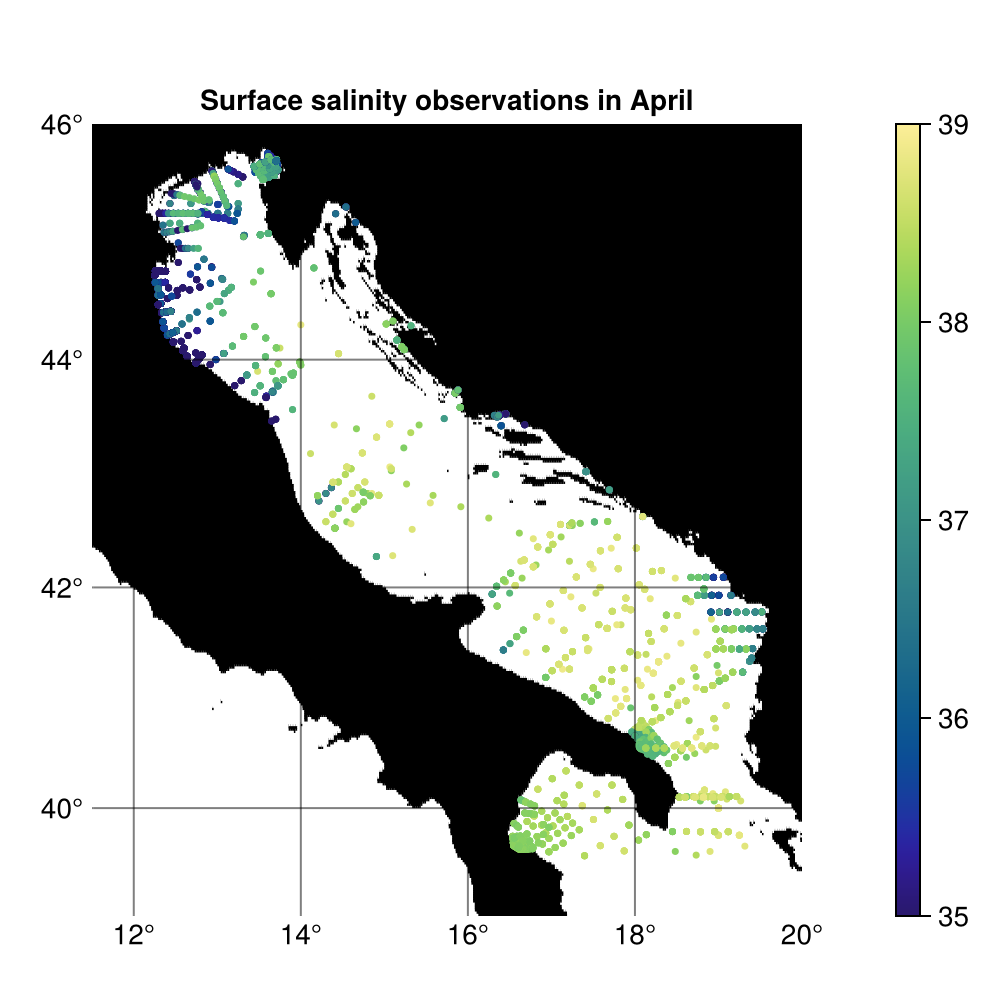

In [22]:
fig = Figure(size=(500, 500))
ax = GeoAxis(fig[1,1], dest = "+proj=merc", title="Surface salinity observations in April", xticks=10.:2.:20., yticks=38.:2.:48.)
GeoMakie.heatmap!(ax, lonmask, latmask, mask, colormap=:binary)
sc = scatter!(ax, obslon[sel], obslat[sel], color=obsval[sel], markersize=5, colorrange=(35, 39.), colormap=cmapS)
xlims!(ax, lonr[1], lonr[end])
ylims!(ax, latr[1], latr[end])
Colorbar(fig[1,2], sc)
fig

In [26]:
fi,s = DIVAndrun(mask0,(pm,pn),(xi,yi),(obslon[sel], obslat[sel]), obsval[sel] .- mean(obsval[sel]), (2.5, 2.5), 0.5);

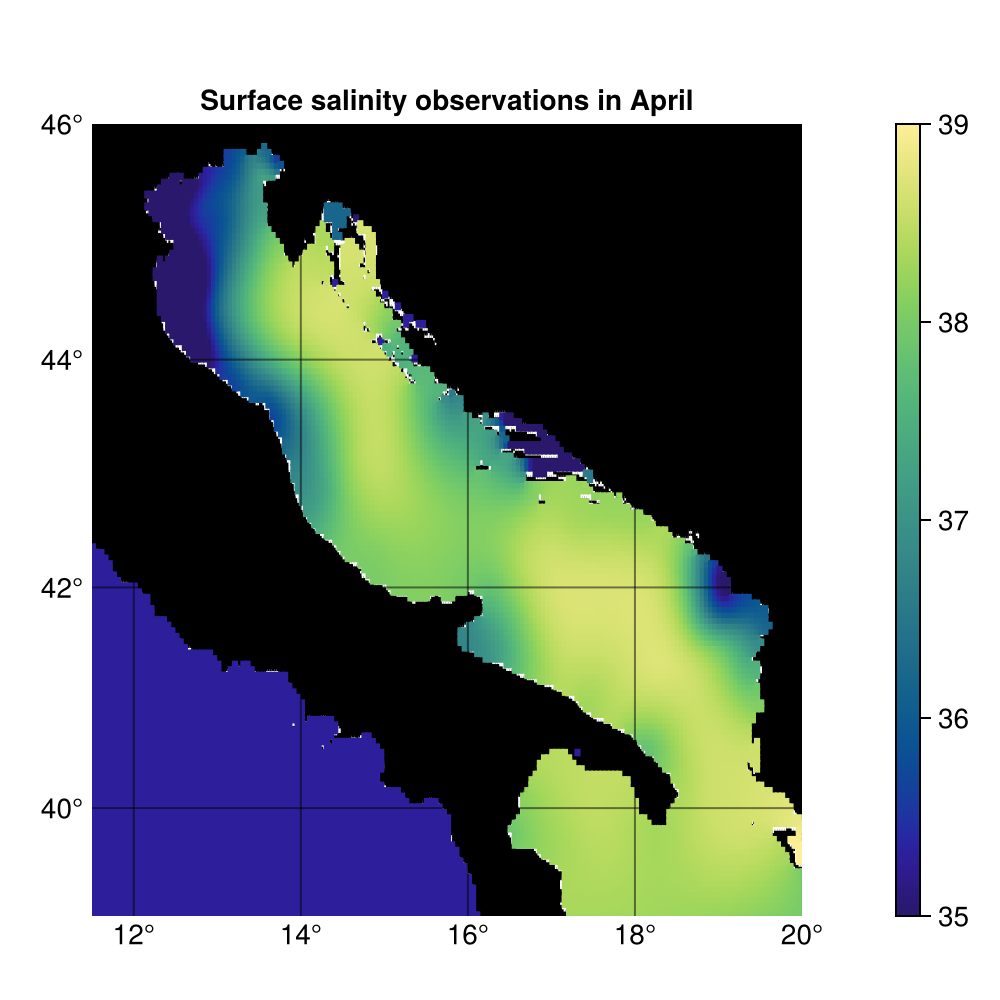

In [27]:
fig = Figure(size=(500, 500))
ax = GeoAxis(fig[1,1], dest = "+proj=merc", title="Surface gridded field", xticks=10.:2.:20., yticks=38.:2.:48.)
GeoMakie.heatmap!(ax, lonmask, latmask, mask, colormap=:binary)
hm = heatmap!(ax, lonr, latr, fi .+ mean(obsval[sel]), colorrange=(35, 39.), colormap=cmapS)
xlims!(ax, lonr[1], lonr[end])
ylims!(ax, latr[1], latr[end])
Colorbar(fig[1,2], sc)
fig